In [1]:
# importing libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
DATA_PATH = "../../dataset/anterior_images_clf/"
classes = ['no', 'yes']
model_name = "anterior_images_clf"

MODEL_PATH = f"../models/{model_name}/"
num_classes = len(classes)

In [3]:
# setting parameter values
path = DATA_PATH
img_height,img_width=384, 384
batch_size=32

# loading the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2, # data is split 80-20
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

# loading the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 208 files belonging to 2 classes.
Using 167 files for training.
Found 208 files belonging to 2 classes.
Using 41 files for validation.


In [4]:
# loading pretrained transfer learning model
base_model = keras.applications.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    classes=120
    )

for layer in base_model.layers: # freezes base model layers
    layer.trainable = False

# adds dense layers for fine tuning
model2 = Sequential()
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(1024, activation='relu'))
model2.add(Dense(1024, activation='relu'))
model2.add(Dense(num_classes, activation='softmax'))

In [5]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 module_wrapper (ModuleWrapp  (None, 1280)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 1024)             1311744   
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 1024)             1049600   
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 2)                2

In [6]:
# sets the optimizer, loss function and evaluation metrics
model2.compile(optimizer='adam', 
               loss='categorical_crossentropy', 
               metrics=['accuracy',
                        keras.metrics.Precision(name='precision'),
                        keras.metrics.Recall(name='recall')])

# initiates training of the model (only dense layers are changed)
history2 = model2.fit(  
    train_ds,
    epochs=10,
    batch_size=128,
    validation_data=val_ds
)

Epoch 1/10
6/6 [==============================] - 84s 4s/step - loss: 0.1352 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - val_loss: 1.1933e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/10
6/6 [==============================] - 5s 770ms/step - loss: 8.8743e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.0934e-07 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
6/6 [==============================] - 5s 768ms/step - loss: 9.7080e-08 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 7.8504e-08 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/10
6/6 [==============================] - 5s 777ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.2336e-08 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/10
6/6 [==============================] - 5s 779ms/step - loss: 0.0000e+00 - a

In [7]:
# saves model history to a pickle file
import pickle
with open(f"{MODEL_PATH}{model_name}.pkl", "wb") as f:
    pickle.dump(history2.history,f)

model2.save_weights(f"{MODEL_PATH}{model_name}.h5")

In [10]:
# running inference on randomly selected images

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

model2.load_weights(f"{MODEL_PATH}{model_name}.h5")

1/1 [==============================] - 0s 211ms/step


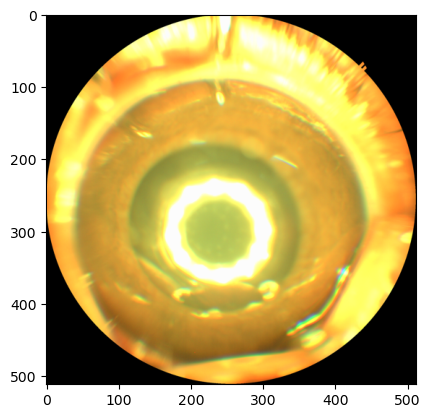

Ground Truth: yes | Prediction: yes (100.00%)

1/1 [==============================] - 0s 174ms/step


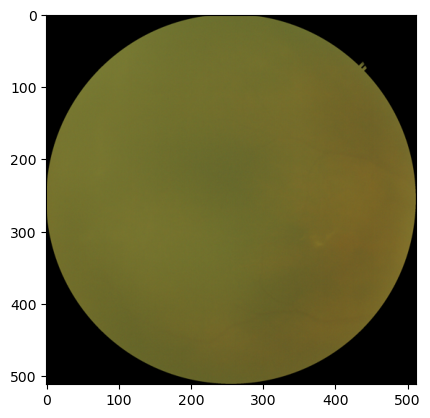

Ground Truth: no | Prediction: no (100.00%)

1/1 [==============================] - 0s 158ms/step


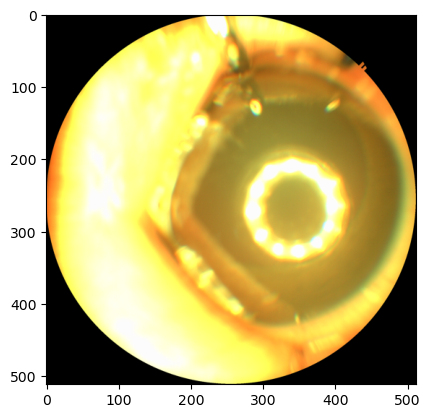

Ground Truth: yes | Prediction: yes (100.00%)

1/1 [==============================] - 0s 163ms/step


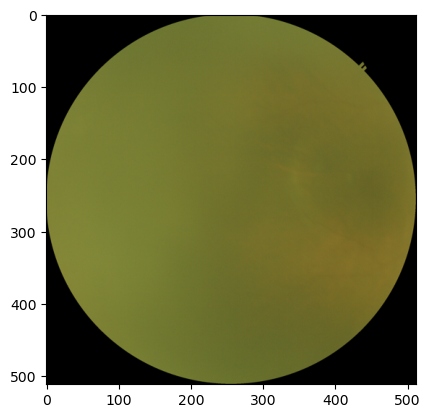

Ground Truth: no | Prediction: no (100.00%)

1/1 [==============================] - 0s 162ms/step


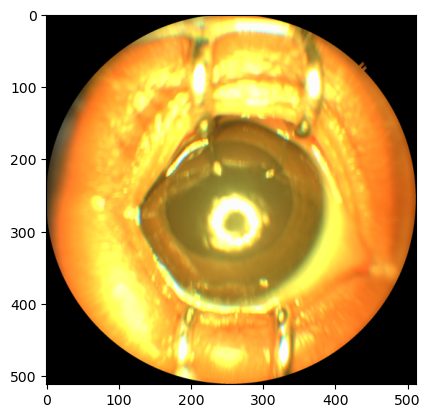

Ground Truth: yes | Prediction: yes (100.00%)



In [20]:
import os

# class1_images = os.listdir(path + r"\1")
# class2_images = os.listdir(path + r"\2")
# class3_images = os.listdir(path + r"\3")
# image_names = [class1_images, class2_images, class3_images]

image_names = []
for img_class in os.listdir(DATA_PATH):
    imgs = os.listdir(f"{DATA_PATH}{img_class}")
    image_names.append(imgs)

num_examples = 5

for i in range(num_examples):
    index = np.random.randint(0, num_classes)
    ground_truth = classes[index]
    image_name = np.random.choice(image_names[index])
    img_path = f"{DATA_PATH}{ground_truth}/{image_name}"

    img = keras.preprocessing.image.load_img(img_path, target_size=(384, 384))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    
    predictions = model2.predict(img_array)
    prediction = np.argmax(predictions[0])
    plt.imshow(Image.open(img_path))
    plt.show()
    print("Ground Truth:", classes[index], end=" ")
    print(f"| Prediction: {classes[prediction]} ({100 * predictions[0][prediction]:.2f}%)\n")